In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import scipy.stats as stats
import os 
import h5py
import sys
import tensorflow.keras.backend as K
import re
%matplotlib inline 

In [2]:
model_name = "PreLSTM_sinLoss"

In [3]:
# Throw away lepton mass 
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_pt', 'wl_eta', 'wl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

output_length = len(output_keys)
input_length = len(input_keys)
crop0 =  100000 

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def jet_existence_dict():
    dic = {}
    for key in phi_keys:
        variable = key.split('_')[0]
        if bool(re.match('^j[0-9]+$', variable)): # If the variable is a jet
            v = np.array(dataset.get(variable + '_pt'))[0:crop0]
            dic[key] = (v>1)*1
        else:
            dic[key] = np.ones(crop0, dtype=int)
    return dic
        
def phi1_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    x = w - 2*np.pi*(w>np.pi)
    y = x - (1-exist)*np.pi*1.1
    y = y-mean
    z = y/max0
    return z

def invphi1_transform(z, max0, mean, exist):
    y = z*max0+mean
    x = y+(1-exist)*np.pi*1.1
    w = x + 2*np.pi*(x<0)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def phi2_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    # x = w - 2*np.pi*(w>np.pi)
    y = w - (1-exist)*0.2
    z = y/(np.pi)
    return z

def invphi2_transform(z, max0, mean, exist):
    y = z*np.pi
    x = y+(1-exist)*0.2
    # w = x + 2*np.pi*(x<0)
    arr = (x + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0 

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 

def final_maxmean(array):
    means = np.mean(array, axis=0)
    array = array - means
    maxs = np.max(np.abs(array), axis=0)
    maxs = maxs + (maxs==0.0)*1
    array = array/maxs
    maxmean = np.stack([maxs, means], axis=1)
    return array, maxmean 

def inverse_final_maxmean(array, maxmean0):
    return array*maxmean0[:,0] + maxmean0[:,1]

def scale_arrays(keys, maxmean_dict):
    exist_dict = jet_existence_dict()
    lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
    
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[key]
            if key == 'tl_phi' or key == 'wl_phi':
                z = phi1_transform(var, max0, mean, exist) 
            else:
                z = phi2_transform(var, max0, mean, exist)
        elif key in pt_keys:
            max0, mean = maxmean_dict['pt']
            z = pt_transform(var, max0, mean)
        elif key in m_keys:
            max0, mean = maxmean_dict['m']
            z = pt_transform(var, max0, mean)
        else:
            max0, mean = maxmean_dict[key.split('_')[1]]
            z = meanmax_transform(var, max0, mean)
        arrays.append(z)
    arrays = np.stack(arrays, axis=1)
    return final_maxmean(arrays)

def invscale_arrays(keys, arrays, maxmean_dict, maxmean0):
    arrays = inverse_final_maxmean(arrays, maxmean0)
    exist_dict = jet_existence_dict()

    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        full_key = keys[i]
        key = keys[i].split('_')[1]
        if key == 'pt':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        elif key=='phi':
            max0, mean = maxmean_dict[key]
            exist = exist_dict[full_key]
            if full_key == 'tl_phi' or full_key == 'wl_phi':
                total.append(invphi1_transform(z, max0, mean, exist))
            else:
                total.append(invphi2_transform(z, max0, mean, exist))
        elif key=='m':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        else:
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
            
    return np.stack(total,axis=1)



    

In [7]:
# Convert into numpy arrays and mean normalize

maxmean = get_maxmean_dict()
total_input, TI_maxmean0 = scale_arrays(input_keys, maxmean)

total_output, TO_maxmean0 = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean, TO_maxmean0)

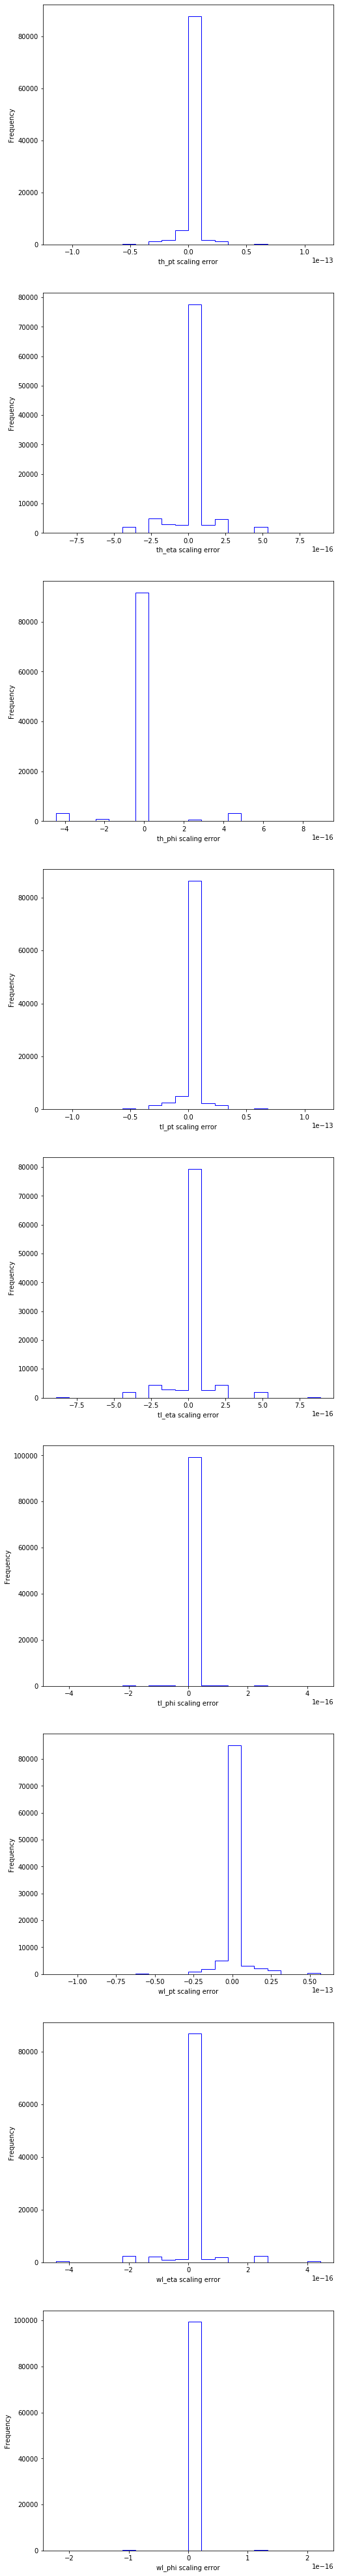

In [8]:
# Test inverse scaling

if False:
    plt.figure(figsize=(8,8*output_length))
    for i in range(len(output_keys)):
        plt.subplot(output_length, 1, i+1)
        plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
        plt.xlabel(output_keys[i] + " scaling error")
        plt.ylabel('Frequency')

In [9]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [10]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(80000, 36) (80000, 9)
(20000, 36) (20000, 9)


In [11]:
# Histograms of output variables 
show = False

if show:
    plt.figure(figsize=(8,8*output_length))
    for i in range(0, output_length):
        plt.subplot(output_length, 1, i+1)
        plt.hist(train_output[:,i], 20, histtype='step')
        plt.xlabel(output_keys[i])
        plt.ylabel('Frequency')

In [12]:
# Histograms of input variables 
show = False

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [15]:
# Build model

def custom_loss(tru, predict):
    return K.mean(K.square(K.sin(np.pi/2*(tru-predict))))
                  
# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(output_keys),  activation='linear')
    ])
                  
    losses = [custom_loss if output_keys[i].split('_')[1] == 'phi' 
              else 'mse' for i in range(len(output_keys))]
    
    model.compile(loss=losses, optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [16]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               18944     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 128)              

In [17]:
# Fit model

Epochs= 2048

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Epoch 1/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0621 - mse: 0.0553 - val_loss: 0.0608 - val_mse: 0.0541
Epoch 2/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0619 - mse: 0.0551 - val_loss: 0.0606 - val_mse: 0.0539
Epoch 3/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0617 - mse: 0.0549 - val_loss: 0.0604 - val_mse: 0.0537
Epoch 4/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0615 - mse: 0.0547 - val_loss: 0.0602 - val_mse: 0.0535
Epoch 5/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0612 - mse: 0.0545 - val_loss: 0.0600 - val_mse: 0.0533
Epoch 6/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0610 - mse: 0.0543 - val_loss: 0.0597 - val_mse: 0.0530
Epoch 7/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0607 - mse: 0.0540 - val_loss: 0.0594 - val_mse: 0.0528
Epoch 8/2048
125/125 [==============================] - 1s 5ms

Epoch 62/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0439 - mse: 0.0379 - val_loss: 0.0432 - val_mse: 0.0371
Epoch 63/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0438 - mse: 0.0378 - val_loss: 0.0431 - val_mse: 0.0371
Epoch 64/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0438 - mse: 0.0378 - val_loss: 0.0430 - val_mse: 0.0370
Epoch 65/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0437 - mse: 0.0377 - val_loss: 0.0430 - val_mse: 0.0370
Epoch 66/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0437 - mse: 0.0377 - val_loss: 0.0429 - val_mse: 0.0369
Epoch 67/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0436 - mse: 0.0376 - val_loss: 0.0429 - val_mse: 0.0369
Epoch 68/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0436 - mse: 0.0376 - val_loss: 0.0428 - val_mse: 0.0369
Epoch 69/2048
125/125 [==============================] 

125/125 [==============================] - 1s 5ms/step - loss: 0.0404 - mse: 0.0349 - val_loss: 0.0399 - val_mse: 0.0343
Epoch 123/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0404 - mse: 0.0348 - val_loss: 0.0398 - val_mse: 0.0343
Epoch 124/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0403 - mse: 0.0348 - val_loss: 0.0398 - val_mse: 0.0342
Epoch 125/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0403 - mse: 0.0347 - val_loss: 0.0397 - val_mse: 0.0342
Epoch 126/2048
125/125 [==============================] - 1s 6ms/step - loss: 0.0402 - mse: 0.0347 - val_loss: 0.0397 - val_mse: 0.0341
Epoch 127/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0402 - mse: 0.0346 - val_loss: 0.0396 - val_mse: 0.0341
Epoch 128/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0401 - mse: 0.0346 - val_loss: 0.0396 - val_mse: 0.0340
Epoch 129/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0380 - mse: 0.0328 - val_loss: 0.0377 - val_mse: 0.0325
Epoch 183/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0380 - mse: 0.0328 - val_loss: 0.0376 - val_mse: 0.0324
Epoch 184/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0380 - mse: 0.0328 - val_loss: 0.0376 - val_mse: 0.0324
Epoch 185/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0379 - mse: 0.0328 - val_loss: 0.0376 - val_mse: 0.0324
Epoch 186/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0379 - mse: 0.0327 - val_loss: 0.0376 - val_mse: 0.0324
Epoch 187/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0379 - mse: 0.0327 - val_loss: 0.0375 - val_mse: 0.0324
Epoch 188/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0379 - mse: 0.0327 - val_loss: 0.0375 - val_mse: 0.0323
Epoch 189/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0367 - mse: 0.0318 - val_loss: 0.0365 - val_mse: 0.0316
Epoch 243/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0367 - mse: 0.0318 - val_loss: 0.0364 - val_mse: 0.0316
Epoch 244/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0367 - mse: 0.0318 - val_loss: 0.0364 - val_mse: 0.0316
Epoch 245/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0366 - mse: 0.0318 - val_loss: 0.0364 - val_mse: 0.0315
Epoch 246/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0366 - mse: 0.0318 - val_loss: 0.0364 - val_mse: 0.0315
Epoch 247/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0366 - mse: 0.0317 - val_loss: 0.0364 - val_mse: 0.0315
Epoch 248/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0366 - mse: 0.0317 - val_loss: 0.0364 - val_mse: 0.0315
Epoch 249/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0311 - val_loss: 0.0356 - val_mse: 0.0310
Epoch 303/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0311 - val_loss: 0.0356 - val_mse: 0.0310
Epoch 304/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0311 - val_loss: 0.0356 - val_mse: 0.0310
Epoch 305/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0311 - val_loss: 0.0356 - val_mse: 0.0310
Epoch 306/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0311 - val_loss: 0.0356 - val_mse: 0.0310
Epoch 307/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0356 - mse: 0.0311 - val_loss: 0.0356 - val_mse: 0.0310
Epoch 308/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0356 - mse: 0.0310 - val_loss: 0.0356 - val_mse: 0.0310
Epoch 309/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0349 - mse: 0.0306 - val_loss: 0.0350 - val_mse: 0.0306
Epoch 363/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0349 - mse: 0.0306 - val_loss: 0.0350 - val_mse: 0.0306
Epoch 364/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0349 - mse: 0.0306 - val_loss: 0.0350 - val_mse: 0.0306
Epoch 365/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0349 - mse: 0.0305 - val_loss: 0.0350 - val_mse: 0.0306
Epoch 366/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0349 - mse: 0.0305 - val_loss: 0.0350 - val_mse: 0.0306
Epoch 367/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0349 - mse: 0.0305 - val_loss: 0.0350 - val_mse: 0.0306
Epoch 368/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0349 - mse: 0.0305 - val_loss: 0.0349 - val_mse: 0.0306
Epoch 369/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0343 - mse: 0.0301 - val_loss: 0.0345 - val_mse: 0.0303
Epoch 423/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0343 - mse: 0.0301 - val_loss: 0.0345 - val_mse: 0.0303
Epoch 424/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0343 - mse: 0.0301 - val_loss: 0.0345 - val_mse: 0.0303
Epoch 425/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0343 - mse: 0.0301 - val_loss: 0.0345 - val_mse: 0.0303
Epoch 426/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0343 - mse: 0.0301 - val_loss: 0.0345 - val_mse: 0.0303
Epoch 427/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0343 - mse: 0.0301 - val_loss: 0.0345 - val_mse: 0.0303
Epoch 428/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0343 - mse: 0.0301 - val_loss: 0.0345 - val_mse: 0.0303
Epoch 429/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0298 - val_loss: 0.0341 - val_mse: 0.0301
Epoch 483/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0298 - val_loss: 0.0341 - val_mse: 0.0301
Epoch 484/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0298 - val_loss: 0.0341 - val_mse: 0.0301
Epoch 485/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0297 - val_loss: 0.0341 - val_mse: 0.0301
Epoch 486/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0337 - mse: 0.0297 - val_loss: 0.0341 - val_mse: 0.0301
Epoch 487/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0337 - mse: 0.0297 - val_loss: 0.0341 - val_mse: 0.0301
Epoch 488/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0337 - mse: 0.0297 - val_loss: 0.0341 - val_mse: 0.0301
Epoch 489/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0294 - val_loss: 0.0338 - val_mse: 0.0299
Epoch 543/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0294 - val_loss: 0.0338 - val_mse: 0.0299
Epoch 544/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0294 - val_loss: 0.0338 - val_mse: 0.0299
Epoch 545/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0294 - val_loss: 0.0338 - val_mse: 0.0299
Epoch 546/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0294 - val_loss: 0.0338 - val_mse: 0.0299
Epoch 547/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0294 - val_loss: 0.0338 - val_mse: 0.0299
Epoch 548/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0294 - val_loss: 0.0338 - val_mse: 0.0299
Epoch 549/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0329 - mse: 0.0292 - val_loss: 0.0335 - val_mse: 0.0298
Epoch 603/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0329 - mse: 0.0292 - val_loss: 0.0335 - val_mse: 0.0298
Epoch 604/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0329 - mse: 0.0292 - val_loss: 0.0335 - val_mse: 0.0298
Epoch 605/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0329 - mse: 0.0292 - val_loss: 0.0335 - val_mse: 0.0298
Epoch 606/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0329 - mse: 0.0291 - val_loss: 0.0335 - val_mse: 0.0298
Epoch 607/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0329 - mse: 0.0291 - val_loss: 0.0335 - val_mse: 0.0298
Epoch 608/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0329 - mse: 0.0291 - val_loss: 0.0335 - val_mse: 0.0298
Epoch 609/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0289 - val_loss: 0.0333 - val_mse: 0.0297
Epoch 663/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0289 - val_loss: 0.0333 - val_mse: 0.0297
Epoch 664/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0289 - val_loss: 0.0333 - val_mse: 0.0297
Epoch 665/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0289 - val_loss: 0.0333 - val_mse: 0.0297
Epoch 666/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0289 - val_loss: 0.0333 - val_mse: 0.0297
Epoch 667/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0289 - val_loss: 0.0333 - val_mse: 0.0297
Epoch 668/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0289 - val_loss: 0.0333 - val_mse: 0.0297
Epoch 669/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0287 - val_loss: 0.0332 - val_mse: 0.0296
Epoch 723/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0287 - val_loss: 0.0332 - val_mse: 0.0296
Epoch 724/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0287 - val_loss: 0.0332 - val_mse: 0.0296
Epoch 725/2048
125/125 [==============================] - ETA: 0s - loss: 0.0322 - mse: 0.028 - 1s 5ms/step - loss: 0.0322 - mse: 0.0287 - val_loss: 0.0331 - val_mse: 0.0296
Epoch 726/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0287 - val_loss: 0.0331 - val_mse: 0.0296
Epoch 727/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0287 - val_loss: 0.0331 - val_mse: 0.0296
Epoch 728/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0286 - val_loss: 0.0331 - val_mse: 0.0296
Epoch 729/2048
125/125 [=

125/125 [==============================] - 1s 5ms/step - loss: 0.0319 - mse: 0.0284 - val_loss: 0.0330 - val_mse: 0.0296
Epoch 783/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0319 - mse: 0.0284 - val_loss: 0.0330 - val_mse: 0.0296
Epoch 784/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0319 - mse: 0.0284 - val_loss: 0.0330 - val_mse: 0.0296
Epoch 785/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0319 - mse: 0.0284 - val_loss: 0.0330 - val_mse: 0.0296
Epoch 786/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0319 - mse: 0.0284 - val_loss: 0.0330 - val_mse: 0.0296
Epoch 787/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0319 - mse: 0.0284 - val_loss: 0.0330 - val_mse: 0.0295
Epoch 788/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0319 - mse: 0.0284 - val_loss: 0.0330 - val_mse: 0.0295
Epoch 789/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0295
Epoch 843/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0295
Epoch 844/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0295
Epoch 845/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0295
Epoch 846/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0295
Epoch 847/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0295
Epoch 848/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0295
Epoch 849/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0280 - val_loss: 0.0328 - val_mse: 0.0295
Epoch 903/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0280 - val_loss: 0.0328 - val_mse: 0.0295
Epoch 904/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0280 - val_loss: 0.0328 - val_mse: 0.0295
Epoch 905/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0280 - val_loss: 0.0328 - val_mse: 0.0295
Epoch 906/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0280 - val_loss: 0.0328 - val_mse: 0.0295
Epoch 907/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0280 - val_loss: 0.0328 - val_mse: 0.0295
Epoch 908/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0280 - val_loss: 0.0328 - val_mse: 0.0295
Epoch 909/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0278 - val_loss: 0.0327 - val_mse: 0.0294
Epoch 963/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0278 - val_loss: 0.0327 - val_mse: 0.0294
Epoch 964/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0278 - val_loss: 0.0327 - val_mse: 0.0294
Epoch 965/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0310 - mse: 0.0278 - val_loss: 0.0327 - val_mse: 0.0294
Epoch 966/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0310 - mse: 0.0278 - val_loss: 0.0327 - val_mse: 0.0294
Epoch 967/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0310 - mse: 0.0278 - val_loss: 0.0327 - val_mse: 0.0294
Epoch 968/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0310 - mse: 0.0278 - val_loss: 0.0327 - val_mse: 0.0294
Epoch 969/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0276 - val_loss: 0.0326 - val_mse: 0.0294
Epoch 1023/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0276 - val_loss: 0.0326 - val_mse: 0.0294
Epoch 1024/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0276 - val_loss: 0.0326 - val_mse: 0.0294
Epoch 1025/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0276 - val_loss: 0.0326 - val_mse: 0.0294
Epoch 1026/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0276 - val_loss: 0.0326 - val_mse: 0.0294
Epoch 1027/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0276 - val_loss: 0.0326 - val_mse: 0.0294
Epoch 1028/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0276 - val_loss: 0.0326 - val_mse: 0.0294
Epoch 1029/2048
125/125 [==============================] 

Epoch 1082/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0306 - mse: 0.0274 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1083/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0306 - mse: 0.0274 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1084/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0274 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1085/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0274 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1086/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0274 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1087/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0274 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1088/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0274 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1089/2048
125/125 [================

Epoch 1142/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0272 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1143/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0272 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1144/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0272 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1145/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0272 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1146/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0272 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1147/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0272 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1148/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0272 - val_loss: 0.0325 - val_mse: 0.0294
Epoch 1149/2048
125/125 [================

Epoch 1202/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0270 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1203/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0270 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1204/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0270 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1205/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0270 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1206/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0270 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1207/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0270 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1208/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0270 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1209/2048
125/125 [================

Epoch 1262/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0298 - mse: 0.0268 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1263/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0298 - mse: 0.0268 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1264/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0298 - mse: 0.0268 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1265/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0298 - mse: 0.0268 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1266/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0298 - mse: 0.0268 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1267/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0298 - mse: 0.0268 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1268/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0298 - mse: 0.0268 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1269/2048
125/125 [================

Epoch 1322/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0296 - mse: 0.0267 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1323/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0296 - mse: 0.0267 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1324/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0296 - mse: 0.0267 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1325/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0296 - mse: 0.0267 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1326/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0296 - mse: 0.0266 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1327/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0296 - mse: 0.0266 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1328/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0296 - mse: 0.0266 - val_loss: 0.0324 - val_mse: 0.0294
Epoch 1329/2048
125/125 [================

Epoch 1382/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0294 - mse: 0.0265 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1383/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0294 - mse: 0.0265 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1384/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0294 - mse: 0.0265 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1385/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0294 - mse: 0.0265 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1386/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0294 - mse: 0.0265 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1387/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0294 - mse: 0.0265 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1388/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0294 - mse: 0.0265 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1389/2048
125/125 [================

Epoch 1442/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0292 - mse: 0.0263 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1443/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0292 - mse: 0.0263 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1444/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0292 - mse: 0.0263 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1445/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0292 - mse: 0.0263 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1446/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0292 - mse: 0.0263 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1447/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0292 - mse: 0.0263 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1448/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0292 - mse: 0.0263 - val_loss: 0.0323 - val_mse: 0.0294
Epoch 1449/2048
125/125 [================

In [18]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: PreLSTM_sinLoss/assets


Text(0.5, 1.0, 'MSE loss')

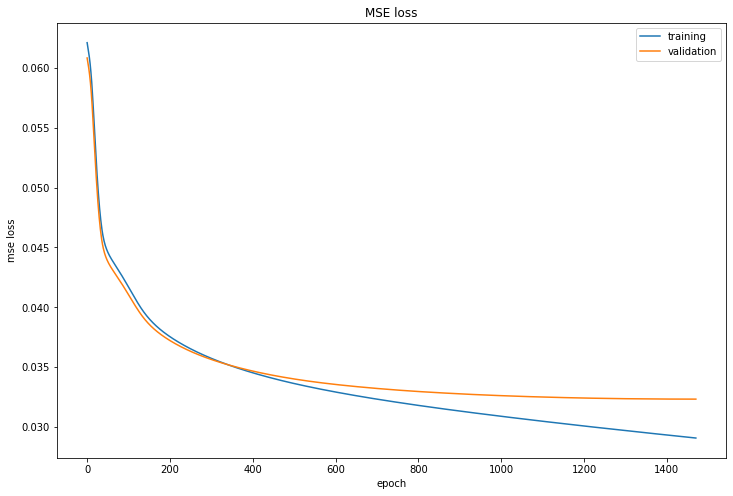

In [19]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [20]:
predictions = model.predict(test_input)

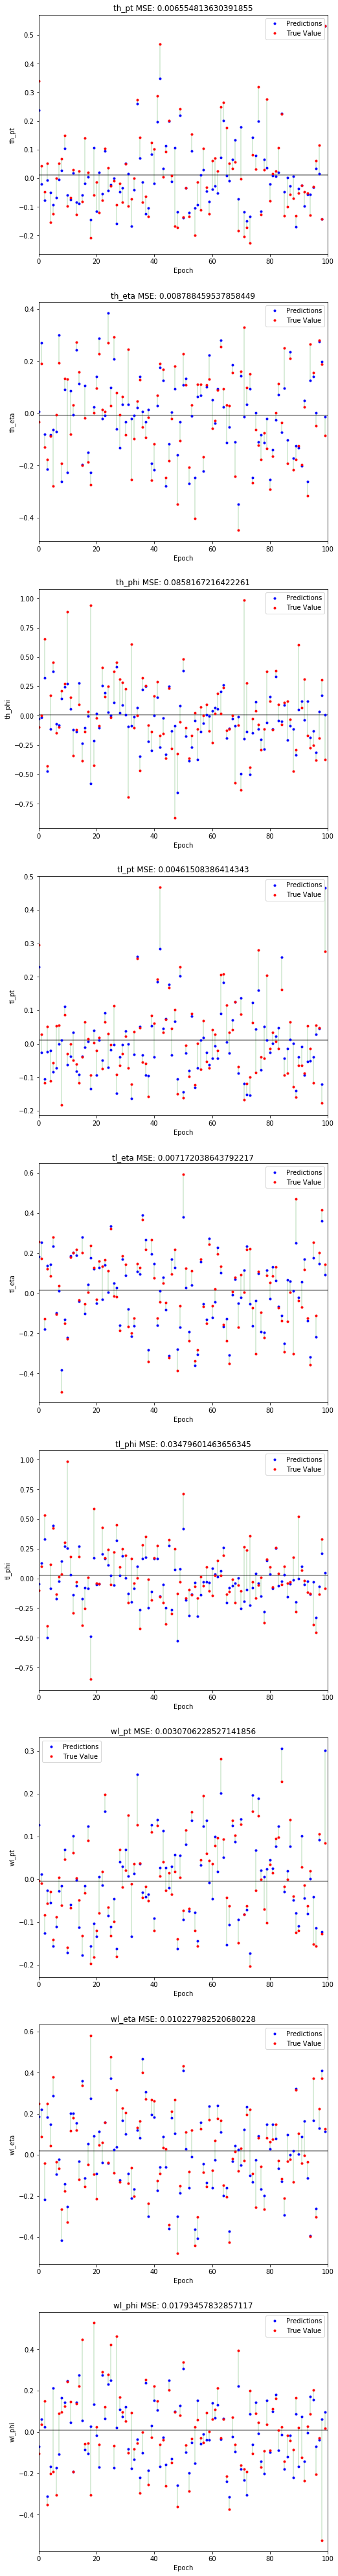

In [21]:

# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [22]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.030088884555777764
th_pt MSE :  0.0071930445
th_eta MSE :  0.0123691134
th_phi MSE :  0.1178094396
tl_pt MSE :  0.0048947662
tl_eta MSE :  0.0100008455
tl_phi MSE :  0.0784869591
wl_pt MSE :  0.0040292617
wl_eta MSE :  0.0093661388
wl_phi MSE :  0.0266503923


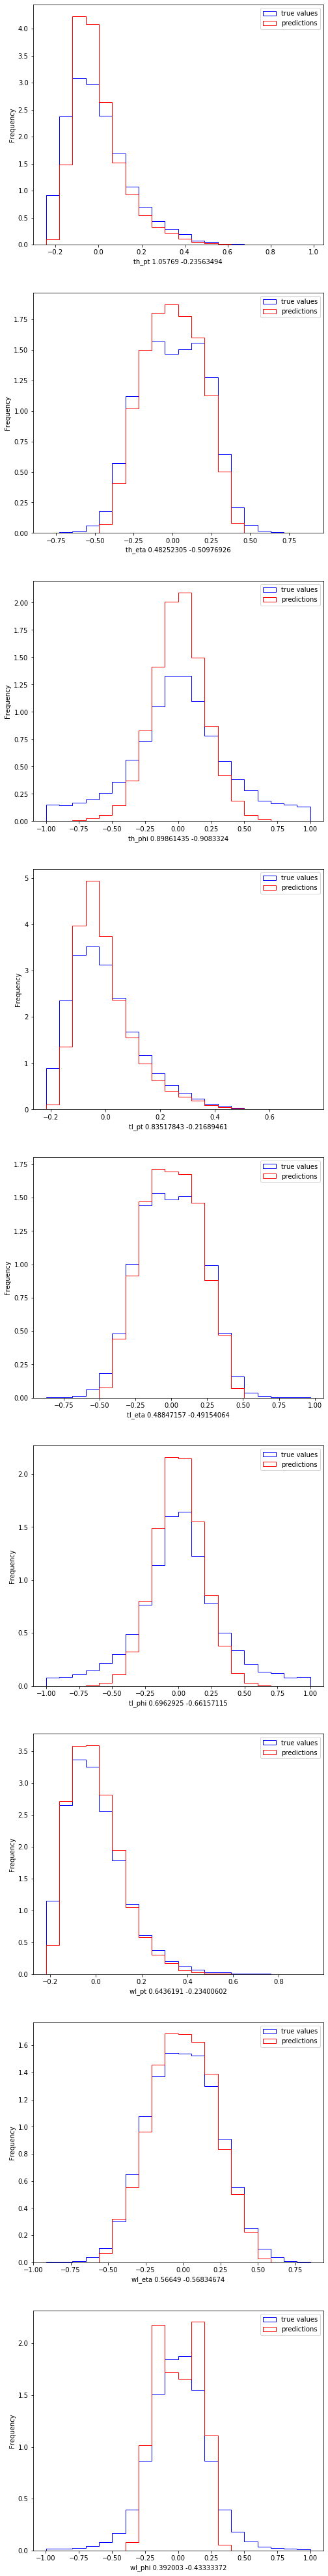

In [23]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [24]:
total_output, TO_maxmean0 = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean, TO_maxmean0)[split:,:]

total_predictions = model.predict(total_input)
predict_scaled = invscale_arrays(output_keys, total_predictions, maxmean, TO_maxmean0)[split:,:]


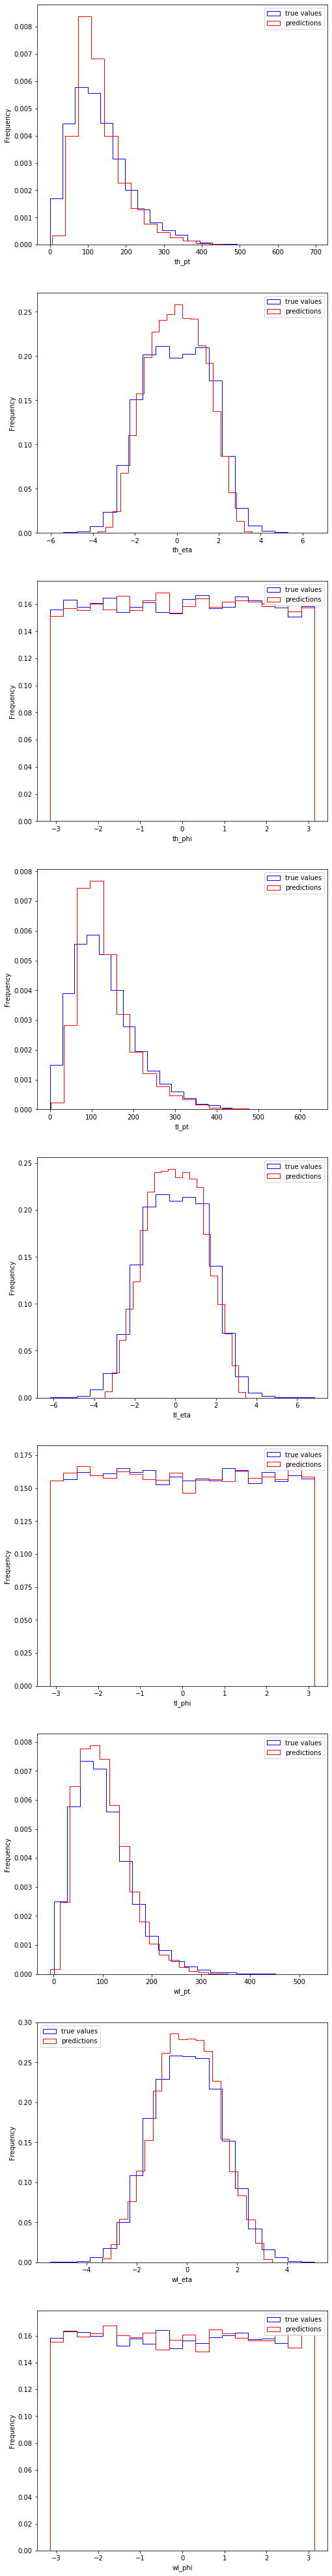

In [25]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
# out_scaled = invscale_arrays(output_keys, test_output, maxmean)
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [27]:
for i in range(output_length):
    if output_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  2058.2138041738
Original Scale th_eta MSE :  0.6804232924
Original Scale th_phi MSE :  1.0593592785
Original Scale tl_pt MSE :  1773.4867674867
Original Scale tl_eta MSE :  0.5004536212
Original Scale tl_phi MSE :  0.7217276605
Original Scale wl_pt MSE :  846.8522748270
Original Scale wl_eta MSE :  0.3347168718
Original Scale wl_phi MSE :  0.2572056339


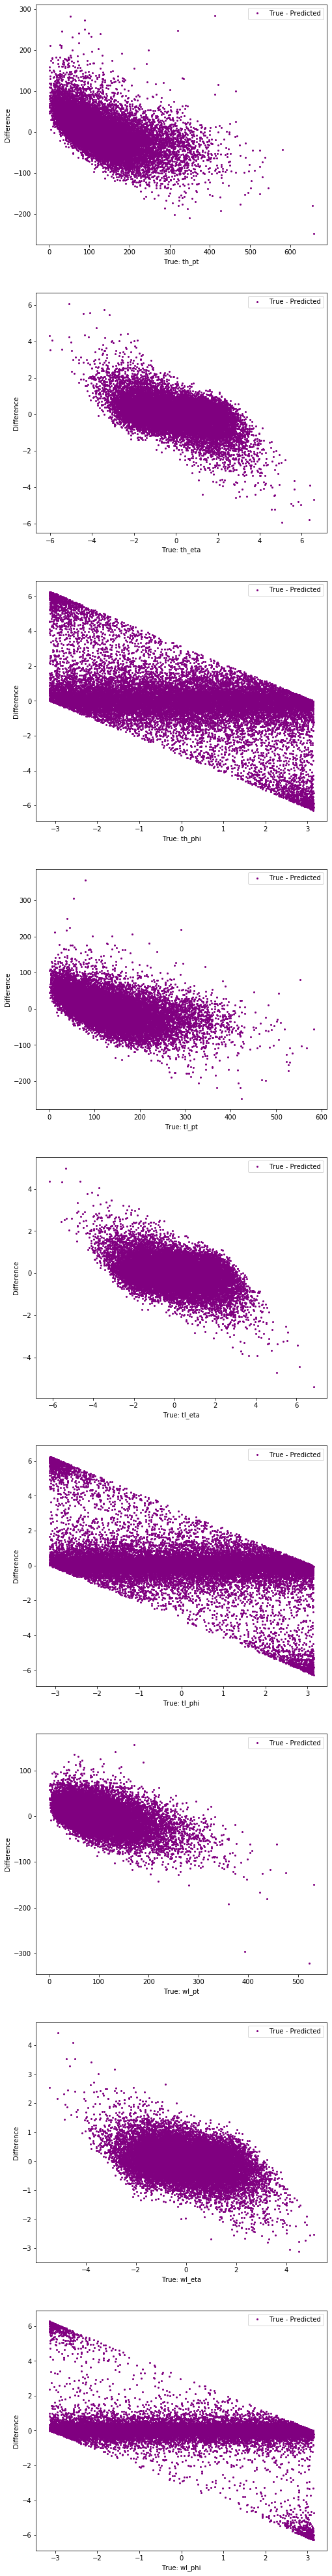

In [26]:
plt.figure(figsize=(8,8*output_length))
for i in range(output_length):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + output_keys[i])
    plt.legend()
    plt.ylabel('Difference')